# 1. Data Exploration

In [129]:
# Import data manipulation libraries
import numpy as np
import pandas as pd

# Import data visualisation libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rc
import seaborn as sns

# Import necessary modules and functions from scikit-learn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set graph defaults
plt.rc('font', family='serif', size=10)
plt.rc('legend', fontsize=10)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['CMU Serif']
plt.rcParams['axes.unicode_minus'] = False

In [111]:
# Read in data
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test = pd.read_csv("X_test.csv")

### 1.1 Data Summary

In [79]:
# Merge data
df = y_train.join(X_train)

# View sample of data
df.head()

,class,ra,dec,rowv,colv,sky_u,sky_g,sky_r,sky_i,sky_z,...,psffwhm_z,redshift,waveMin,waveMax,wCoverage,spectroFlux_u,spectroFlux_g,spectroFlux_r,spectroFlux_i,spectroFlux_z
0,GALAXY,193.501580,-3.151499,0.001558,-0.003090,1.485249,1.918151,4.959499,10.499020,32.93853,...,1.294442,0.084459,3797.519,9200.258,0.3679,6.787869,16.94696,36.79082,55.93771,71.01184
1,STAR,193.285642,49.189768,-0.000454,0.002103,0.995259,1.377672,3.382322,7.532795,24.20448,...,1.124869,-0.000174,3801.894,9183.326,0.3692,39.508860,70.64217,116.61060,145.60520,160.23250
2,GALAXY,150.991449,6.370981,-0.002789,-0.003372,1.061719,1.655002,3.331498,5.424337,14.75673,...,1.171532,0.118706,3823.843,9183.326,0.3775,13.236710,43.51529,114.39910,170.16740,227.93710
3,GALAXY,187.682335,-2.672471,-0.000691,-0.003080,1.267892,1.849097,5.440842,10.755410,34.14946,...,1.431124,0.091831,3805.397,9206.615,0.3792,8.067329,28.89629,69.58190,102.09230,135.12630
4,GALAXY,148.597128,57.509841,-0.000070,0.004862,1.312444,1.804335,4.948974,8.895027,30.10676,...,1.086376,0.079584,3806.274,9206.615,0.3662,13.455560,37.11879,72.44161,101.22820,116.49640


In [80]:
# Get summary of data
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 63 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ra             100000 non-null  float64
 1   dec            100000 non-null  float64
 2   rowv           100000 non-null  float64
 3   colv           100000 non-null  float64
 4   sky_u          100000 non-null  float64
 5   sky_g          100000 non-null  float64
 6   sky_r          100000 non-null  float64
 7   sky_i          100000 non-null  float64
 8   sky_z          100000 non-null  float64
 9   psfMag_u       100000 non-null  float64
 10  psfMag_g       100000 non-null  float64
 11  psfMag_r       100000 non-null  float64
 12  psfMag_i       100000 non-null  float64
 13  psfMag_z       100000 non-null  float64
 14  fiberMag_u     100000 non-null  float64
 15  fiberMag_g     100000 non-null  float64
 16  fiberMag_r     100000 non-null  float64
 17  fiberMag_i     100000 non-null

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif


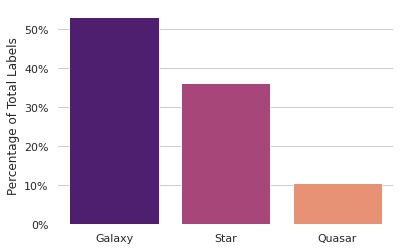

In [81]:
# Get composition of class
data = df['class'].value_counts(normalize=True).to_frame().reset_index()
data["class"] = data["class"] * 100
data['index'] = ["Galaxy", "Star", "Quasar"]

# Plot data
ax = sns.barplot(data=data, x="index", y="class", palette="magma")
ax.set(title = "",
       ylabel = "Percentage of Total Labels", xlabel = "")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.set(font="CMU Serif", style="whitegrid")
sns.despine(left=True, bottom=True)
ax

# Export plot
fig = ax.get_figure()
fig.savefig("composition.png", dpi=1200, bbox_inches="tight") 

In [82]:
# Get table summarising key properties of predictors
data_summary = pd.DataFrame()
data_summary["mean"] = round(X_train.mean(), 4)
data_summary["median"] = round(X_train.median(), 4)
data_summary["std"] = round(X_train.std(), 4)
data_summary["min"] = round(X_train.min(), 4)
data_summary["max"] = round(X_train.max(), 4)
data_summary["mean_galaxy"] = round(df[df["class"] == "GALAXY"].mean(), 4)
data_summary["mean_star"] = round(df[df["class"] == "STAR"].mean(), 4)
data_summary["mean_qso"] = round(df[df["class"] == "QSO"].mean(), 4)

# Identify variables where any category is more than one STD from another category
data_summary["sig_dif"] =\
(abs(data_summary["mean_galaxy"] - data_summary["mean_star"]) > data_summary["std"]) |\
(abs(data_summary["mean_galaxy"] - data_summary["mean_qso"]) > data_summary["std"]) |\
(abs(data_summary["mean_star"] - data_summary["mean_qso"]) > data_summary["std"])

data_summary

,mean,median,std,min,max,mean_galaxy,mean_star,mean_qso,sig_dif
ra,177.7861,172.7013,78.6813,0.0045,359.9948,179.8711,174.7982,177.5720,False
dec,24.2011,14.4673,25.5516,-11.2528,68.7315,24.4886,22.7537,27.7266,False
rowv,-0.6997,0.0003,83.6551,-9999.0000,1.3859,-0.5648,-1.1012,0.0008,False
colv,-0.6999,0.0000,83.6551,-9999.0000,2.5169,-0.5650,-1.1013,0.0003,False
sky_u,1.4076,1.3165,0.4308,0.6825,24.2680,1.3993,1.4296,1.3738,False
...,...,...,...,...,...,...,...,...,...
spectroFlux_u,46.5860,19.9633,116.6326,-26.8998,13972.5600,14.7595,97.0370,33.2270,False
spectroFlux_g,99.6105,41.4661,442.0330,-0.9763,72270.1300,36.9710,209.7505,36.0893,False
spectroFlux_r,168.5570,73.3627,1032.8393,-1.5277,189664.3000,77.9445,337.4982,43.6568,False
spectroFlux_i,212.1615,97.3250,1370.8388,-2.8187,260694.5000,113.8499,402.9489,50.9297,False


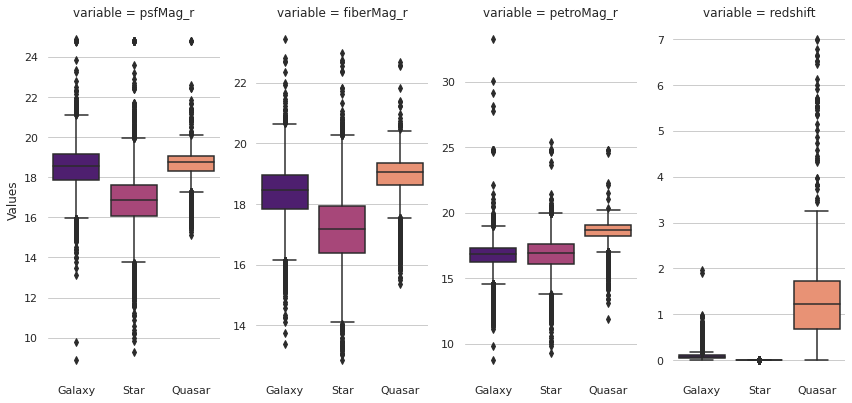

In [83]:
# Identify features with large difference between classes
data = df[["class", "psfMag_r", "fiberMag_r", "petroMag_r", "redshift"]].reset_index()
data = pd.melt(data, id_vars=["index", "class"])
data = data.replace({"class": {"GALAXY": "Galaxy", "STAR": "Star", "QSO": "Quasar"}})

# Plot data
ax = sns.FacetGrid(data, col="variable", height=6, aspect=.5, sharey=False)
ax.map(sns.boxplot, "class", "value", palette="magma")
ax.axes[0,0].set_ylabel('Values')
ax.axes[0,0].set_xlabel("")
ax.axes[0,1].set_xlabel("")
ax.axes[0,2].set_xlabel("")
ax.axes[0,3].set_xlabel("")
sns.set(font="CMU Serif", style="whitegrid")
sns.despine(left=True, bottom=True)

# Export plot
plt.savefig("box.png", dpi=800, bbox_inches="tight") 

### 1.2 Missing Features

In [84]:
# Find rows with missing data in the training set
cols_missing = data_summary[data_summary["min"] == -9999.0].index.to_list()
rows_missing = set()
for i in cols_missing:
    rows_missing.update(df[df[i] == -9999.0].index.to_list())
rows_missing = list(rows_missing)

# Check feature values of these data points
df.iloc[rows_missing, [0]+[i for i in range(30,40)]]

,class,psfFlux_u,psfFlux_g,psfFlux_r,psfFlux_i,psfFlux_z,fiberFlux_u,fiberFlux_g,fiberFlux_r,fiberFlux_i,fiberFlux_z
63781,STAR,0.057147,-7.708914e-02,0.823707,0.204684,7.156742e-01,0.147655,0.023727,0.765306,0.127129,1.086688
83687,GALAXY,22135.560000,6.533272e+04,120264.000000,131317.200000,2.681567e+04,2295.161000,1401.315000,1931.512000,2648.401000,8647.682000
17672,GALAXY,4.066568,9.196280e+00,12.440300,0.000000,0.000000e+00,3.381735,9.726506,13.192110,0.000000,0.000000
34186,GALAXY,3.111989,8.231052e+00,10.940510,13.623890,2.035846e+01,3.341392,9.850529,17.241220,23.586900,29.210190
9388,GALAXY,110805.400000,1.032865e+06,282344.100000,442496.400000,2.644816e+06,5510.905000,2696.281000,4508.544000,3277.970000,31483.380000
17964,STAR,16326.700000,1.028621e+05,192483.300000,236388.100000,1.359325e+05,1259.432000,1413.451000,1758.536000,2235.528000,10291.710000
56975,STAR,14056.800000,4.160279e+04,82669.730000,95463.710000,2.788610e+04,1982.707000,1407.547000,1438.810000,1793.238000,9237.306000
69391,STAR,11732.600000,4.194520e+04,79913.990000,94356.020000,5.201054e+04,1508.893000,1639.713000,846.008200,2391.468000,5067.019000


In [85]:
# Find rows with missing data in the test set
df_test = pd.DataFrame()
df_test["min"] = X_test.min()

test_cols_missing = df_test[df_test["min"]==-9999].index.to_list()
test_rows_missing = set()
for i in test_cols_missing:
    test_rows_missing.update(X_test[X_test[i] == -9999].index.to_list())
test_rows_missing = list(test_rows_missing)

# Check feature values of these data points
X_test.iloc[test_rows_missing, 29:39]

,psfFlux_u,psfFlux_g,psfFlux_r,psfFlux_i,psfFlux_z,fiberFlux_u,fiberFlux_g,fiberFlux_r,fiberFlux_i,fiberFlux_z
19587,24.889590,222.373000,550.663900,752.686100,0.000000,17.868360,158.655800,403.07610,555.79640,0.00000
28842,2.772142,6.887607,9.631545,12.817530,0.000000,3.865454,10.613480,16.05266,21.53673,23.25403
59979,694.226000,324.502300,152.946100,226.786100,1613.678000,1987.382000,552.441800,972.61350,740.23190,4607.35100
12589,7498.331000,35834.160000,64055.310000,77484.290000,59094.020000,3253.328000,962.744400,1398.46100,1433.54000,6263.67300
40622,10312.630000,46012.050000,77294.160000,86125.380000,76498.770000,9020.655000,1074.069000,1360.18300,2424.09500,5216.76600
22799,2946.780000,502.651200,586.022500,504.944700,2056.843000,1610.543000,923.909500,1149.62300,1232.65000,4613.87800
8847,4653.996000,101963.400000,416880.100000,614129.800000,253248.600000,2843.485000,1529.865000,2141.64100,3390.87700,17181.91000
53618,11089.940000,71019.100000,137752.000000,174132.000000,123588.200000,3756.793000,1444.504000,2108.27800,2539.26800,7976.80600
7254,1.626891,6.698616,8.626271,7.935394,9.274754,3.053455,8.543215,13.26176,16.67564,20.74356
74684,9318.505000,23338.700000,43674.730000,49354.900000,18955.810000,4116.718000,1173.457000,1161.46300,1492.47800,9268.52100


In [86]:
# Drop rows with values -9999 in the training set
X_train_del = X_train.drop(rows_missing)
y_train_del = y_train.drop(rows_missing)
df_del = y_train_del.join(X_train_del)

# Get table summarising key properties of predictors in the new training set
data_summary_del = pd.DataFrame()
data_summary_del["mean"] = round(X_train_del.mean(), 4)
data_summary_del["median"] = round(X_train_del.median(), 4)
data_summary_del["std"] = round(X_train_del.std(), 4)
data_summary_del["min"] = round(X_train_del.min(), 4)
data_summary_del["max"] = round(X_train_del.max(), 4)
data_summary_del["mean_galaxy"] = round(df_del[df_del["class"] == "GALAXY"].mean(), 4)
data_summary_del["std_galaxy"] = round(df_del[df_del["class"] == "GALAXY"].std(), 4)
data_summary_del["min_galaxy"] = df_del[df_del["class"] == "GALAXY"].min()
data_summary_del["max_galaxy"] = df_del[df_del["class"] == "GALAXY"].max()
data_summary_del["mean_star"] = round(df_del[df_del["class"] == "STAR"].mean(), 4)
data_summary_del["std_star"] = round(df_del[df_del["class"] == "STAR"].std(), 4)
data_summary_del["min_star"] = df_del[df_del["class"] == "STAR"].min()
data_summary_del["max_star"] = df_del[df_del["class"] == "STAR"].max()

data_summary_del.iloc[29:39,].T

,psfFlux_u,psfFlux_g,psfFlux_r,psfFlux_i,psfFlux_z,fiberFlux_u,fiberFlux_g,fiberFlux_r,fiberFlux_i,fiberFlux_z
mean,33.4902,99.1853,157.6145,192.8303,222.9926,25.5685,73.4217,116.7676,145.5551,177.5329
median,14.7969,36.2725,60.4151,77.6557,94.2497,11.6039,32.1449,55.5751,73.552,88.6839
std,129.1467,393.9828,785.3214,984.8647,970.7595,95.5798,131.5557,194.2589,229.5552,395.9792
min,-0.6638,0.0602,-0.0231,-10.3383,-2.7426,-0.7052,0.0239,0.3808,-29.994,0.2909
max,23795.91,45684.21,117311.3,158232.9,142763.1,17045.0,4035.14,7279.273,12871.39,25960.98
mean_galaxy,7.8144,29.2043,56.1316,79.2597,107.6955,7.4501,29.2262,59.9892,87.2142,115.3737
std_galaxy,11.3437,37.5449,71.7216,98.418,127.6631,9.2489,30.9493,64.0575,91.4352,123.481
min_galaxy,-0.222954,0.23302,-0.023081,-0.000117,-0.317256,-0.070088,0.193357,0.380811,0.586987,0.29086
max_galaxy,800.1533,2998.136,5520.72,5919.424,6665.977,594.045,1442.002,3157.148,3685.752,4023.374
mean_star,72.1832,219.6778,339.346,400.6302,440.776,53.1543,151.365,224.1884,262.0925,307.8624


By manually checking every feature, one can notice that those points with missing values tend to have extreme feature values, espcially in psfMag, fiberMag, petroMag, psfFlux, and spectroFlux (either beyond 5 sigma within their clusters, or even beyond max).

Suspect they are in the boundary of their own clusters, e.g. 9388th point (galaxy) is reasonably close to 17964th point (star). We choose to delete these points with missing data, despite that they are highly probably lying in the very boundary of their own clusters and hence may provide useful information.

1. There are only 8 of them and we still have hundreds of similar points (though probably not as extreme). 

2. They are so extreme that certain galaxy data appear like star data and vice versa (i.e. one can imagine this is one of the inseparable cases where there are two big clusters, but each cluster seems to contain a point from the other class), which is unusual according to summary statistics in data_summary. Measurements with such a large magnitude measuring objects very far away must come with larger uncertainties. Hence, one might argue that they can be treated as outliers (or at least as uncertain data that might pollute the dataset).

3. If we don't delete them, we will need to first estimate the missing values and then use the estimated values in model training, so we are using the same dataset twice. If we delete them from the training set, we can add them to the validation set so that we have labeled data to try algorithms for predicting new points with missing values.

### 1.3 Outliers

In [87]:
# Get row ids more than ten standard deviations away from mean (ignoring -9999)
cols_outlier = []
rows_outlier = set()
for i in X_train_del.columns.to_list():
    diff = abs(df_del[i] - data_summary_del.loc[i]["mean"]) / data_summary_del.loc[i]["std"]
    diff_rows = diff[diff > 10].index.to_list()
    rows_outlier.update(diff_rows)
    if len(diff_rows) > 0:
        cols_outlier.append(i)
rows_outlier = list(rows_outlier)
      
len(rows_outlier)

1475

### 1.4 Multicollinearity

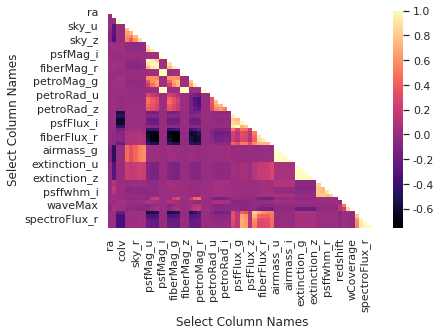

In [88]:
# Plot correlation matrix
mask = np.triu(np.ones_like(df.corr()))
ax = sns.heatmap(df.corr(), mask=mask, cmap="magma")
ax.set(title = "",
       ylabel = "Select Column Names", xlabel = "Select Column Names")
sns.set(font="CMU Serif", style="whitegrid")
sns.despine(left=True, bottom=True)
ax

# Export plot
fig = ax.get_figure()
fig.savefig("correlation.png", dpi=800, bbox_inches="tight") 

In [89]:
# Get list of top correlated columns
top_corr = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False)
top_corr = top_corr.to_frame(name="correlation").reset_index()
top_corr[top_corr["level_0"] != top_corr["level_1"]].head(30)

,level_0,level_1,correlation
63,extinction_z,extinction_u,1.000000
64,extinction_u,extinction_z,1.000000
65,extinction_i,extinction_g,1.000000
66,extinction_g,extinction_i,1.000000
67,extinction_z,extinction_g,1.000000
68,extinction_g,extinction_z,1.000000
69,extinction_g,extinction_u,1.000000
70,extinction_u,extinction_g,1.000000
71,extinction_r,extinction_z,1.000000
72,extinction_z,extinction_r,1.000000


# 2. Pre-Processing

In [90]:
# Import machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

### 2.1 Data Cleaning
We remove the data points with missing values here. We will in the end use them to "test" our algorithm for predicting with missing values.

In [91]:
# Transform labels to numerical values
def map_str_to_int(x):
    if x == "GALAXY":
        return 0
    elif x == "STAR":
        return 1
    else: # QSO -> 2
        return 2
    
y_train_int = pd.DataFrame()
y_train_int["class"] = y_train["class"].transform(map_str_to_int)

# Remove rows with missing data
X_train_clean = X_train.drop(rows_missing)
y_train_clean = y_train_int.drop(rows_missing)

# Remove rows with outlier and missing data
# X_train_clean = X_train.drop(list(set(rows_outlier)+set(rows_missing)))
# y_train_clean = y_train_int.drop(list(set(rows_outlier)+set(rows_missing)))

# Shuffle and split clean data into training and test sets
X_train_clean, X_valid_clean, y_train_clean, y_valid_clean = \
    train_test_split(X_train_clean, y_train_clean, test_size=0.1, random_state=42)

# Scale data
scaler = StandardScaler()
scaler.fit(X_train_clean)

X_train_clean = pd.DataFrame(scaler.transform(X_train_clean))
X_valid_clean = pd.DataFrame(scaler.transform(X_valid_clean))

X_train_clean.columns = X_train.columns
X_valid_clean.columns = X_train.columns

### 2.2 PCA Dimensionality Reduction
We don't use LDA since LDA behaves less well when the number of classes is small (in our case we can only get 2 reduced coordinates at most, which is clearly insufficient).

Non-linear dimensionality reduction tools such as tSNE or UMAP are stochastic and used more often for visualization (unsupervised). As PCA is simple to implement and directly reduces multi-collinearity, we will stick to PCA.

In [92]:
# Get principal components
K = 25
columns = ["PCA" + str(i + 1) for i in range(K)]
pca = PCA(n_components = K)
pca.fit(X_train_clean)

# Label principal components
V = pd.DataFrame(data = pca.components_.T,
                 columns = columns,
                 index = X_train_clean.columns)
# print('Principal components:\n', V) 

# Calculate eigenvalues of the projections
lam = pca.explained_variance_
print('\n Eigenvalues/variance of the projections:\n', lam)


 Eigenvalues/variance of the projections:
 [16.97308945  7.41494635  6.31704801  5.25329271  4.85779323  4.06706415
  2.08772474  1.82401794  1.64154438  1.07560255  1.01703457  0.99871967
  0.98936485  0.95932302  0.79511048  0.77670557  0.68624319  0.65437211
  0.60896643  0.51510281  0.42031706  0.33804726  0.33328536  0.30529077
  0.30352025]


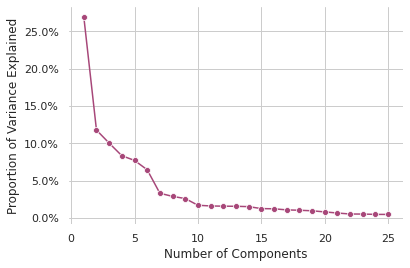

In [93]:
# Create scree plot to determine the optimal number of principal components
ax = sns.lineplot(y=pca.explained_variance_ratio_*100, x=range(1, 26), marker='o', color="#a74779")
ax.set(title = "",
       ylabel = "Proportion of Variance Explained", 
       xlabel = "Number of Components")
sns.set(font = "CMU Serif", style="whitegrid")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.despine(left=True, bottom=True)
ax

# Export plot
fig = ax.get_figure()
fig.savefig("scree.png", dpi=1200, bbox_inches="tight") 

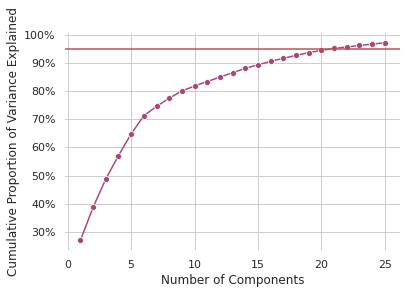

In [94]:
var_ratio = np.cumsum(pca.explained_variance_ratio_)

ax = sns.lineplot(y=var_ratio*100, x=range(1, 26), marker='o', color="#a74779")
ax.set(title = "",
       ylabel = "Cumulative Proportion of Variance Explained", 
       xlabel = "Number of Components")
ax.axhline(y = 95, color = 'r', linestyle = '-')
sns.set(font = "CMU Serif", style="whitegrid")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.despine(left=True, bottom=True)
ax

# Export plot
fig = ax.get_figure()
fig.savefig("cum_var.png", dpi=1200, bbox_inches="tight") 

In [95]:
# Compute the projections onto the principal components. Adhering to the 95% rule, K=21.
Z_train_pca = pca.transform(X_train_clean)[:, :21]
Z_valid_pca = pca.transform(X_valid_clean)[:, :21]
X_train_clean_pca = pd.DataFrame(Z_train_pca, columns=columns[:21])
X_valid_clean_pca = pd.DataFrame(Z_valid_pca, columns=columns[:21])

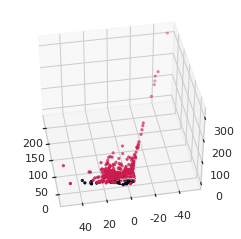

In [96]:
# Visualize PCA in 3D
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(Z_train_pca[:, 0], Z_train_pca[:, 1], Z_train_pca[:, 2], c=y_train_clean.iloc[:,0], marker=".")
ax.elev = 40
ax.azim = 170
ax.dist = 10

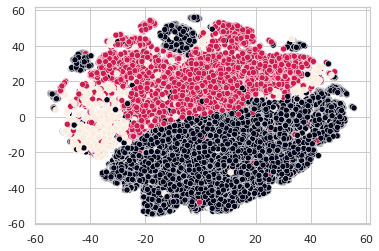

In [195]:
# Visualize PCA in 2D via tSNE (NB: This takes 30 min to run)
# from sklearn.manifold import TSNE
# tsne_2d = TSNE(n_components=2, random_state=0)
# projections_2d = tsne_2d.fit_transform(X_train_clean_pca.iloc[:,:12])
# sns.scatterplot(x=projections_2d[:,0], y=projections_2d[:,1], c=y_train_clean.iloc[:,0])

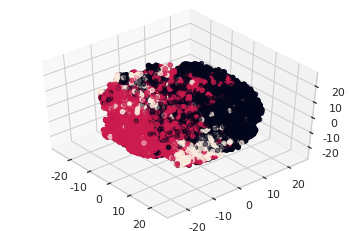

In [240]:
# Visualize PCA in 3D via tSNE (NB: This takes 80 min to run)
# from sklearn.manifold import TSNE
# tsne_3d = TSNE(n_components=3, random_state=0)
# projections_3d = tsne_3d.fit_transform(X_train_clean_pca.iloc[:,:12])
# ax = plt.axes(projection='3d')
# ax.scatter3D(projections_3d[:,0], projections_3d[:,1], projections_3d[:,2], c=y_train_clean.iloc[:,0])
# ax.elev = 45
# ax.azim = -40
# ax.dist = 10

# 2. Model Fitting

## K Nearest Neighbors

(2 min)

In [131]:
%%time

knn_model = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(1, 11, 1)}

grid_knn = GridSearchCV(knn_model, param_grid, scoring='accuracy', verbose=0)
grid_knn.fit(X_train_clean_pca, y_train_clean)

print("The best parameters are: ", grid_knn.best_params_)

knn_model_final = grid_knn.best_estimator_

The best parameters are:  {'n_neighbors': 3}
Wall time: 1min 57s


### Accuracy

In [132]:
pred_knn = knn_model_final.predict(X_valid_clean_pca)
acc_knn = accuracy_score(y_valid_clean, pred_knn)
print(f'Accuracy on validation set: {acc_knn}')

Accuracy on validation set: 0.977


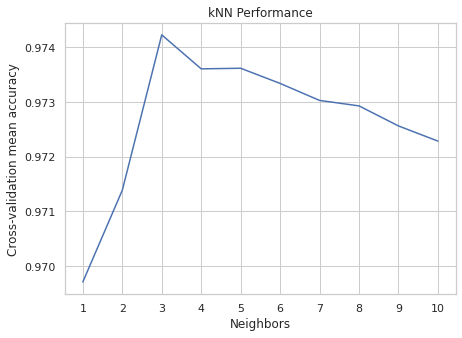

In [133]:
plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, 11, 1), grid_knn.cv_results_['mean_test_score'])
plt.title('kNN Performance')
plt.xlabel('Neighbors')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('Cross-validation mean accuracy');

### Confusion Matrix

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5265
           1       0.97      0.99      0.98      3702
           2       0.97      0.88      0.92      1033

    accuracy                           0.98     10000
   macro avg       0.98      0.95      0.96     10000
weighted avg       0.98      0.98      0.98     10000



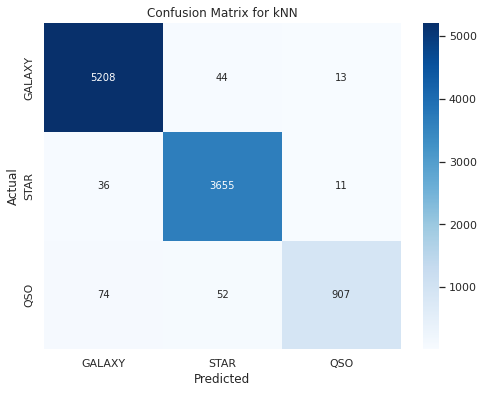

In [134]:
print(classification_report(y_valid_clean, pred_knn))

cm = confusion_matrix(y_valid_clean, pred_knn, labels=[0,1,2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['GALAXY', 'STAR', 'QSO'], 
            yticklabels = ['GALAXY', 'STAR', 'QSO'], cmap=plt.cm.Blues)

plt.title('Confusion Matrix for kNN')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

## Random Forests

(12 min)

In [151]:
%%time

rf_model = RandomForestClassifier()

param_grid = {'n_estimators': np.arange(10, 25, 2), 'max_depth': np.arange(5, 25, 5), 'class_weight': ['balanced']}

grid_rf = GridSearchCV(rf_model, param_grid, scoring='accuracy', verbose=0)
grid_rf.fit(X_train_clean_pca, y_train_clean)

print("The best parameters are: ", grid_rf.best_params_)

rf_model_final = grid_rf.best_estimator_

The best parameters are:  {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 22}
Wall time: 11min 50s


### Accuracy

In [152]:
pred_rf = rf_model_final.predict(X_valid_clean_pca)
acc_rf = accuracy_score(y_valid_clean, pred_rf)
print(f'Accuracy on validation set: {acc_rf}')

Accuracy on validation set: 0.9851


### Confusion Matrix

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5265
           1       0.99      0.99      0.99      3702
           2       0.99      0.91      0.95      1033

    accuracy                           0.99     10000
   macro avg       0.99      0.97      0.98     10000
weighted avg       0.99      0.99      0.98     10000



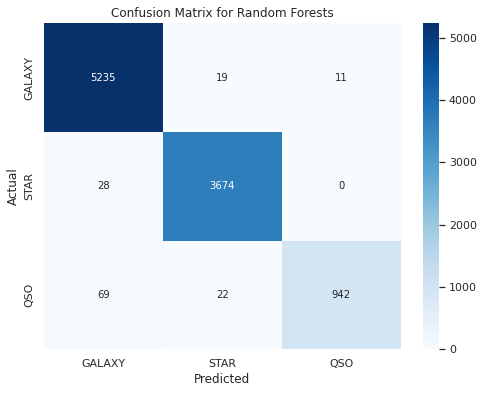

In [153]:
print(classification_report(y_valid_clean, pred_rf))

cm = confusion_matrix(y_valid_clean, pred_rf, labels=[0,1,2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['GALAXY', 'STAR', 'QSO'], 
            yticklabels = ['GALAXY', 'STAR', 'QSO'], cmap=plt.cm.Blues)

plt.title('Confusion Matrix for Random Forests')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

### Feature Importance (This is probably useless since we did PCA)

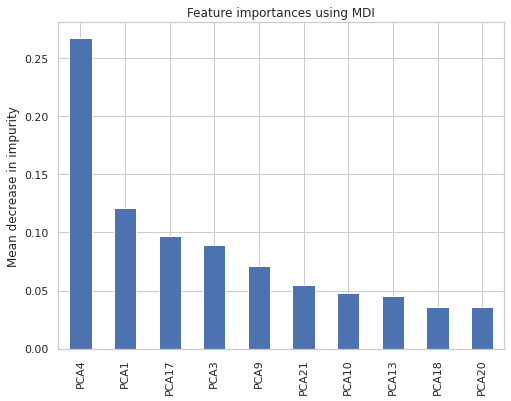

In [154]:
importances = rf_model_final.feature_importances_
feature_names = X_train_clean_pca.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
forest_importances[:10].plot.bar()
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
plt.show();

## Naive Bayes

(<1 sec)

In [155]:
%%time

nb_model = GaussianNB()

param_grid = {}

grid_nb = GridSearchCV(nb_model, param_grid, scoring='accuracy')
grid_nb.fit(X_train_clean_pca, y_train_clean)

# print("The best parameters are: ", grid_nb.best_params_)

nb_model_final = grid_nb.best_estimator_

Wall time: 453 ms


### Accuracy

In [156]:
pred_nb = nb_model_final.predict(X_valid_clean_pca)
acc_nb = accuracy_score(y_valid_clean, pred_nb)
acc_nb

0.9079

### Confusion Matrix

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      5265
           1       0.93      0.84      0.88      3702
           2       0.92      0.86      0.89      1033

    accuracy                           0.91     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.91      0.91      0.91     10000



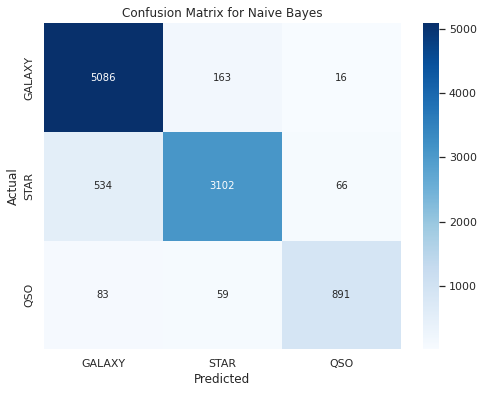

In [157]:
print(classification_report(y_valid_clean, pred_nb))

cm = confusion_matrix(y_valid_clean, pred_nb, labels=[0,1,2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['GALAXY', 'STAR', 'QSO'], 
            yticklabels = ['GALAXY', 'STAR', 'QSO'], cmap=plt.cm.Blues)

plt.title('Confusion Matrix for Naive Bayes')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

## SVM

(12 min)

In [158]:
%%time

svc_model = LinearSVC()

param_grid = {'C': np.logspace(-2, 2, 5), 'penalty': ['l1', 'l2']}

grid_svc = GridSearchCV(svc_model, param_grid, scoring='accuracy', verbose=0)
grid_svc.fit(X_train_clean_pca, y_train_clean)

print("The best parameters are: ", grid_svc.best_params_)

svc_model_final = grid_svc.best_estimator_

The best parameters are:  {'C': 1.0, 'penalty': 'l2'}
Wall time: 12min 41s


### Accuracy

In [159]:
pred_svc = svc_model_final.predict(X_valid_clean_pca)
acc_svc = accuracy_score(y_valid_clean, pred_svc)
print(f'Accuracy on validation set: {acc_svc}')

Accuracy on validation set: 0.9875


### Confusion Matrix

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5265
           1       0.99      0.99      0.99      3702
           2       0.98      0.94      0.96      1033

    accuracy                           0.99     10000
   macro avg       0.99      0.97      0.98     10000
weighted avg       0.99      0.99      0.99     10000



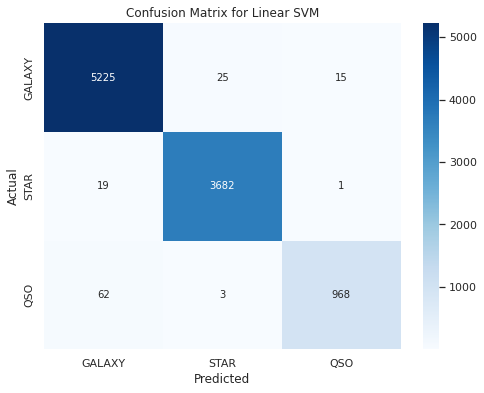

In [160]:
print(classification_report(y_valid_clean, pred_svc))

cm = confusion_matrix(y_valid_clean, pred_svc, labels=[0,1,2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['GALAXY', 'STAR', 'QSO'], 
            yticklabels = ['GALAXY', 'STAR', 'QSO'], cmap=plt.cm.Blues)

plt.title('Confusion Matrix for Linear SVM')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

## AdaBoost

(40 min)

In [161]:
%%time

ada_model = AdaBoostClassifier()

param_grid = {'learning_rate': [0.25, 0.1, 0.01], 'n_estimators': [100, 200, 300]}

grid_ada = GridSearchCV(ada_model, param_grid, scoring='accuracy', verbose=0)
grid_ada.fit(X_train_clean_pca, y_train_clean)

print("The best parameters are: ", grid_ada.best_params_)

ada_model_final = grid_ada.best_estimator_

The best parameters are:  {'learning_rate': 0.25, 'n_estimators': 300}
Wall time: 41min 20s


### Accuracy

In [162]:
pred_ada = ada_model_final.predict(X_valid_clean_pca)
acc_ada = accuracy_score(y_valid_clean, pred_ada)
print(f'Accuracy on validation set: {acc_ada}')

Accuracy on validation set: 0.979


### Confusion Matrix

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5265
           1       0.98      0.99      0.98      3702
           2       0.99      0.90      0.94      1033

    accuracy                           0.98     10000
   macro avg       0.98      0.96      0.97     10000
weighted avg       0.98      0.98      0.98     10000



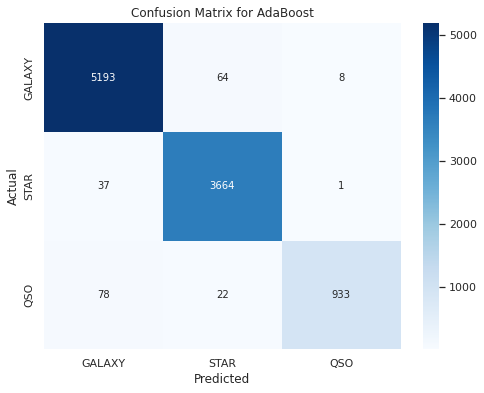

In [163]:
print(classification_report(y_valid_clean, pred_ada))

cm = confusion_matrix(y_valid_clean, pred_ada, labels=[0,1,2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['GALAXY', 'STAR', 'QSO'], 
            yticklabels = ['GALAXY', 'STAR', 'QSO'], cmap=plt.cm.Blues)

plt.title('Confusion Matrix for AdaBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

## XGBoost

<span style="color:red">(5 hrs)</span>

In [64]:
%%time

xgb_model = XGBClassifier()

param_grid = {'learning_rate': [0.25, 0.1, 0.01], 'n_estimators': [100, 200, 300], 'max_depth': [2, 4, 6, 8, 10]}

grid_xgb = GridSearchCV(xgb_model, param_grid, scoring='accuracy', verbose=0)
grid_xgb.fit(X_train_clean_pca, y_train_clean)

print("The best parameters are: ", grid_xgb.best_params_)

xgb_model_final = grid_xgb.best_estimator_

The best parameters are:  {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 300}
Wall time: 4h 59min 10s


### Accuracy

In [67]:
pred_xgb = xgb_model_final.predict(X_valid_clean_pca)
acc_xgb = accuracy_score(y_valid_clean, pred_xgb)
print(f'Accuracy on validation set: {acc_xgb}')

Accuracy on validation set: 0.989


### Confusion Matrix

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5265
           1       1.00      0.99      0.99      3702
           2       0.98      0.94      0.96      1033

    accuracy                           0.99     10000
   macro avg       0.99      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



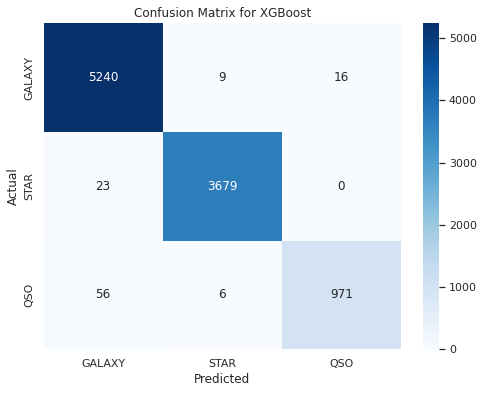

In [68]:
print(classification_report(y_valid_clean, pred_xgb))

cm = confusion_matrix(y_valid_clean, pred_xgb, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['GALAXY', 'STAR', 'QSO'], 
            yticklabels = ['GALAXY', 'STAR', 'QSO'], cmap=plt.cm.Blues)

plt.title('Confusion Matrix for XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

## ROC Curves, AUC

(9 min)

In [118]:
def map_int_to_str(x):
    if x == 0:
        return "GALAXY"
    elif x == 1:
        return "STAR"
    else: 
        return "QSO"

Working on model 1/6
Working on model 2/6
Working on model 3/6
Working on model 4/6
Working on model 5/6
Working on model 6/6
Wall time: 9min 10s


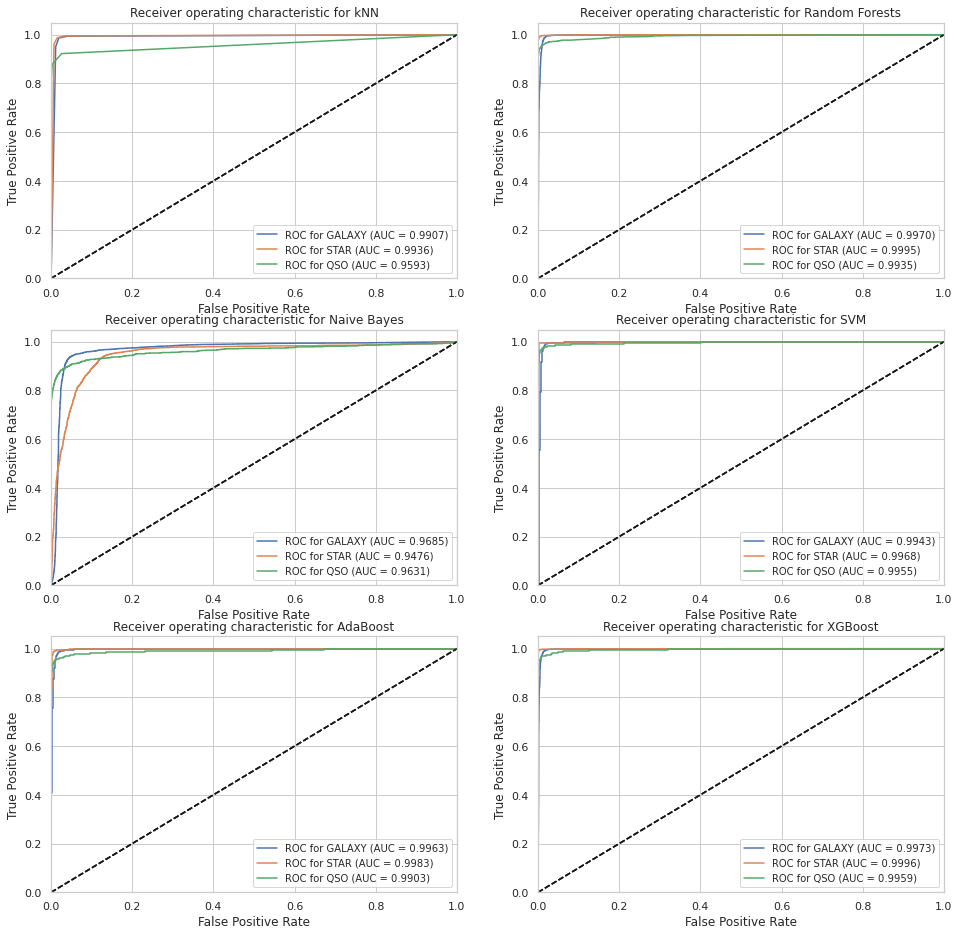

In [150]:
%%time

y_train_bin = label_binarize(y_train_clean, classes=[0,1,2])
y_valid_bin = label_binarize(y_valid_clean, classes=[0,1,2])
n_classes = 3

fig, ax = plt.subplots(3, 2, figsize=(16, 16))

names = ['kNN', 'Random Forests', 'Naive Bayes', 'SVM', 'AdaBoost', 'XGBoost']

for i, model in enumerate([knn_model_final, rf_model_final, nb_model_final, CalibratedClassifierCV(svc_model_final), ada_model_final, xgb_model_final]):
    print(f'Working on model {i+1}/6')
    
    if i == 5:
        xgb_param = model.get_xgb_params()
        extra = {'num_class': 3}
        xgb_param.update(extra)
        model=XGBClassifier(**xgb_param)
        
    # classifier
    clf = OneVsRestClassifier(model)
    y_score = clf.fit(X_train_clean_pca, y_train_bin).predict_proba(X_valid_clean_pca)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_valid_bin[:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Plot of a ROC curve for a specific class
    for j in range(n_classes):
        ax[i//2, i%2].plot(fpr[j], tpr[j], label=f'ROC for {map_int_to_str(j)} (AUC = {roc_auc[j]:.4f})')
        ax[i//2, i%2].plot([0, 1], [0, 1], 'k--')
        ax[i//2, i%2].set_xlim([0.0, 1.0])
        ax[i//2, i%2].set_ylim([0.0, 1.05])
        ax[i//2, i%2].set_xlabel('False Positive Rate')
        ax[i//2, i%2].set_ylabel('True Positive Rate')
        ax[i//2, i%2].set_title(f'Receiver operating characteristic for {names[i]}')
        ax[i//2, i%2].legend(loc="lower right")